# Car reliablity comparison 

in this notebook I take data from the UK DVLA MOT database and reviews of different cars from Edmunds consumer car rating using this two datasets and some different text and network analysis techniques I try to draw comparisons of 3 different small hatchback cars: 

- toyota yaris - 2011-2016
- ford fiesta - 2009 - 2016
- fiat 500 - 2007 - 2016




### Imports

In [68]:
import pandas as pd

import os
import spacy 
from spacy import displacy
import os
import glob
import json
import gzip
import pandas as pd
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Data ingestion

- techniques used: 
- regex: extraction of date and car name

In [22]:
ford_df = pd.read_csv("./car_review_datasets/Scraped_Car_Review_ford.csv", engine='python', encoding='utf-8') 
fiat_df = pd.read_csv("./car_review_datasets/Scraped_Car_Review_fiat.csv", engine='python', encoding='utf-8') 
toyota_df = pd.read_csv("./car_review_datasets/Scrapped_Car_Reviews_Toyota.csv", engine='python', encoding='utf-8') 

In [23]:
ford_df = ford_df.drop('Unnamed: 0', axis=1)
df_fiesta = ford_df[ford_df["Vehicle_Title"].str.contains("Fiesta", na=False)]
df_fiesta["vehicle_age"] = df_fiesta["Vehicle_Title"].str.extract(r'(\d{4})')[0]
df_fiesta["vehicle_age"] = pd.to_numeric(df_fiesta["vehicle_age"])
df_fiesta = df_fiesta[df_fiesta["vehicle_age"] < 2017]
df_fiesta = df_fiesta.reset_index(drop=True)

/tmp/ipykernel_100561/614061907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fiesta["vehicle_age"] = df_fiesta["Vehicle_Title"].str.extract(r'(\d{4})')[0]
/tmp/ipykernel_100561/614061907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fiesta["vehicle_age"] = pd.to_numeric(df_fiesta["vehicle_age"])


In [24]:
fiat_df = fiat_df.drop('Unnamed: 0', axis=1)
df_500 = fiat_df[fiat_df["Vehicle_Title"].str.contains("500", na=False)]
df_500["vehicle_age"] = df_fiesta["Vehicle_Title"].str.extract(r'(\d{4})')[0]
df_500["vehicle_age"] = pd.to_numeric(df_500["vehicle_age"])
df_500 = df_500[df_500["vehicle_age"] < 2017]
df_500 = df_500.reset_index(drop=True)

/tmp/ipykernel_100561/2667345601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500["vehicle_age"] = df_fiesta["Vehicle_Title"].str.extract(r'(\d{4})')[0]
/tmp/ipykernel_100561/2667345601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500["vehicle_age"] = pd.to_numeric(df_500["vehicle_age"])


In [26]:
df_yaris = toyota_df[toyota_df["Vehicle_Title"].str.contains("Yaris", na=False)]
df_yaris["vehicle_age"] = df_yaris["Vehicle_Title"].str.extract(r'(\d{4})')[0]
df_yaris["vehicle_age"] = pd.to_numeric(df_yaris["vehicle_age"])
df_yaris = df_yaris[df_yaris["vehicle_age"] < 2017]
df_yaris = df_yaris.reset_index(drop=True)
df_yaris = df_yaris.drop('Unnamed: 0', axis=1)

/tmp/ipykernel_100561/536882426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yaris["vehicle_age"] = df_yaris["Vehicle_Title"].str.extract(r'(\d{4})')[0]
/tmp/ipykernel_100561/536882426.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yaris["vehicle_age"] = pd.to_numeric(df_yaris["vehicle_age"])


In [28]:
print(df_fiesta.shape)
print(df_500.shape)
print(df_yaris.shape)

(340, 7)
(309, 7)
(450, 7)


#### Mot ingestion

- as the whole Mot dataset is over 40GB large I decided I would use this analysis as a proof of concept and only ingest 100 json files worth of data between the 24-25th of march

- columns found from the MOT datasets: `['registration', 'firstUsedDate', 'registrationDate', 'manufactureDate',
       'primaryColour', 'secondaryColour', 'engineSize', 'model', 'make',
       'fuelType', 'lastMotTestDate', 'motTests', 'lastUpdateTimestamp',
       'dataSource', 'lastUpdateDate', 'lastRunDate', 'lastRunTimestamp',
       'modification']`

to find the full dataset and steps to download can be found here: https://documentation.history.mot.api.gov.uk/

In [58]:
data_dir = './mot_data/'
json_files = glob.glob(os.path.join(data_dir, '*.json.gz'))
all_data = []

for i, file_path in enumerate(json_files):
    if i > 150:
        print("Processing limit reached.")
        break
    try:
        file_records = []
        with gzip.open(file_path, 'rt', encoding='utf-8') as f:
            for i, line in enumerate(f):
                try:
                    if line.strip():  
                        record = json.loads(line)
                        file_records.append(record)
                except json.JSONDecodeError as e:
                    print(f"Error in {os.path.basename(file_path)}, line {i+1}: {str(e)[:100]}")
                    continue
        
        all_data.extend(file_records)
        print(f"Loaded: {os.path.basename(file_path)} - {len(file_records)} records")
    except Exception as e:
        print(f"Failed to process {os.path.basename(file_path)}: {str(e)[:100]}")

# Create DataFrame
if all_data:
    df = pd.DataFrame(all_data)
    
else:
    print("No data was successfully loaded.")

Loaded: delta-light-vehicle_24-03-2025_171.json.gz - 15 records
Loaded: delta-light-vehicle_25-03-2025_265.json.gz - 506 records
Loaded: delta-light-vehicle_25-03-2025_142.json.gz - 499 records
Loaded: delta-light-vehicle_25-03-2025_363.json.gz - 363 records
Loaded: delta-light-vehicle_24-03-2025_24.json.gz - 9 records
Loaded: delta-light-vehicle_24-03-2025_70.json.gz - 6 records
Loaded: delta-light-vehicle_25-03-2025_285.json.gz - 491 records
Loaded: delta-light-vehicle_25-03-2025_196.json.gz - 456 records
Loaded: delta-light-vehicle_24-03-2025_150.json.gz - 6 records
Loaded: delta-light-vehicle_24-03-2025_104.json.gz - 10 records
Loaded: delta-light-vehicle_25-03-2025_165.json.gz - 497 records
Loaded: delta-light-vehicle_24-03-2025_345.json.gz - 12 records
Loaded: delta-light-vehicle_25-03-2025_369.json.gz - 450 records
Loaded: delta-light-vehicle_24-03-2025_128.json.gz - 4 records
Loaded: delta-light-vehicle_24-03-2025_9.json.gz - 5 records
Loaded: delta-light-vehicle_24-03-2025_203

#### MOT dataset view

In [59]:
df.head(3)

registration firstUsedDate registrationDate manufactureDate primaryColour  \
0       L13UMG    2008-08-08       2008-08-08      2008-08-08         White   
1      RA07HSZ    2007-08-08       2007-08-08      2007-08-08        Silver   
2      YA17USZ    2017-06-29       2017-06-29      2017-06-29          Blue   

  secondaryColour  engineSize        model        make fuelType  \
0      Not Stated      1596.0       FIESTA        FORD   Petrol   
1      Not Stated      2460.0  TRANSPORTER  VOLKSWAGEN   Diesel   
2      Not Stated      1995.0          320         BMW   Diesel   

            lastMotTestDate  \
0  2025-03-23T15:24:56.000Z   
1  2025-03-23T10:16:40.000Z   
2  2025-03-23T11:44:47.000Z   

                                            motTests  \
0  [{'completedDate': '2011-08-30T14:52:54.000Z',...   
1  [{'completedDate': '2010-09-08T17:31:31.000Z',...   
2  [{'completedDate': '2020-06-21T06:58:49.000Z',...   

          lastUpdateTimestamp dataSource lastUpdateDate lastRunDate  \
0  2025-03-23 15:24:56.000000       dvsa     2025-03-23  2025-03-24   
1  2025-03-23 10:16:40.000000       dvsa     2025-03-23  2025-03-24   
2  2025-03-23 11:44:47.000000       dvsa     2025-03-23  2025-03-24   

             lastRunTimestamp modification  
0  2025-03-24 05:29:23.392803      UPDATED  
1  2025-03-24 05:29:23.392803      UPDATED  
2  2025-03-24 05:29:23.392803      UPDATED

In [60]:
df['registrationDate'] = pd.to_datetime(df['registrationDate'])
df['manufactureDate'] = pd.to_datetime(df['manufactureDate'])
df['firstUsedDate'] = pd.to_datetime(df['firstUsedDate'])

#### parse out car we are evaluating

In [61]:
ford_fiesta = df[(df["model"] == "FIESTA") &  (df["make"] == "FORD")].copy()
# Filter for Ford Fiesta mk6 (2008-2017)
mot_ford_fiesta_mk6 = ford_fiesta[(ford_fiesta["registrationDate"] >= pd.to_datetime('2008-01-01')) & 
                             (ford_fiesta["registrationDate"] <= pd.to_datetime('2017-12-31'))]

In [62]:
fiat_500 = df[(df["model"] == "500") &  (df["make"] == "FIAT")].copy()
# Filter for Ford Fiesta mk6 (2008-2017)
mot_fiat_500_mk3 = fiat_500[(fiat_500["registrationDate"] >= pd.to_datetime('2008-01-01')) & 
                             (fiat_500["registrationDate"] <= pd.to_datetime('2017-12-31'))]

In [63]:
toyota_yaris = df[(df["model"] == "YARIS") &  (df["make"] == "TOYOTA")].copy()
# Filter yaris (2007-2016)
mot_toyota_yaris = toyota_yaris[(toyota_yaris["registrationDate"] >= pd.to_datetime('2007-01-01')) & 
                             (toyota_yaris["registrationDate"] <= pd.to_datetime('2016-12-31'))]

In [67]:
print(mot_ford_fiesta_mk6.shape)
print(mot_fiat_500_mk3.shape)
print(mot_toyota_yaris.shape)

(1003, 18)
(298, 18)
(251, 18)


# Preliminary analysis: word cloud

- A popular way to get a good general infomation about your dataset is to use word clouds, these are great to gain some quick general infomation about the datasets and topics commonly seen in the data

##### Techniques used: 
- stopwords - remove common words
- text cleaning - remove punctuation and lower text 
- lemmatizing
- wordcloud

#### Review word clouds

In [85]:
import nltk
# nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /home/reaf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/reaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:

def data_cleaning(text, additional_stopwords):
    text = re.sub(r'[^\w\s]', '', text.lower())
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(additional_stopwords)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)


def generate_wordcloud(text, additional_stopwords, title):
    cleaned_text = data_cleaning(text, additional_stopwords)

    print(f"Cleaned text length: {len(cleaned_text)}")
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


(340, 7)
(309, 7)
(450, 7)


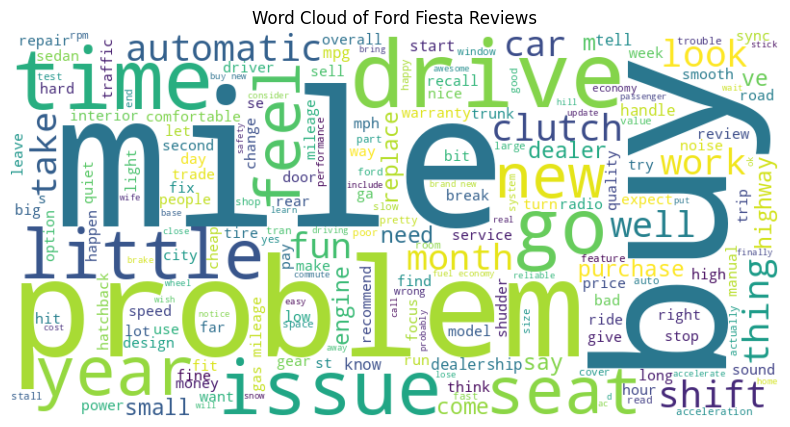

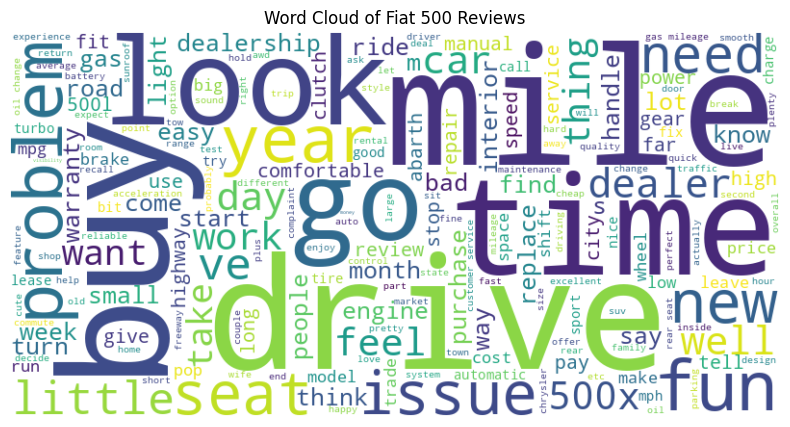

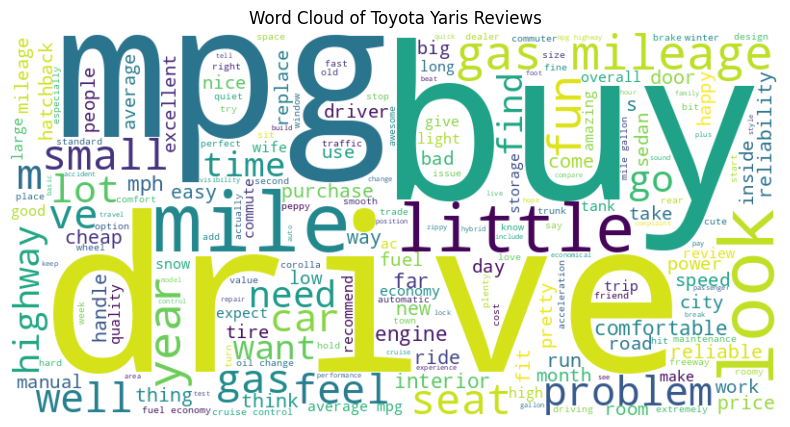

In [91]:
print(df_fiesta.shape)
print(df_500.shape)
print(df_yaris.shape)


all_reviews_fiesta = ' '.join(df_fiesta['Review'].fillna(''))
all_reviews_500 = ' '.join(df_500['Review'].fillna(''))
all_reviews_yaris = ' '.join(df_yaris['Review'].fillna(''))

common_stopwords = {'car', 'vehicle', 'one', 'like', 'drive', 'good', 'great', 'love', 'would', 'say', 'get', "transmission", "drive", "mile"}

generate_wordcloud(all_reviews_fiesta, common_stopwords.union({'ford', 'fiesta'}), 'Word Cloud of Ford Fiesta Reviews')
generate_wordcloud(all_reviews_500, common_stopwords.union({"fiat", "500"}), 'Word Cloud of Fiat 500 Reviews')
generate_wordcloud(all_reviews_yaris, common_stopwords.union({"toyota", "yaris"}), 'Word Cloud of Toyota Yaris Reviews')


# word clouds - Mot


- using ngram - 7 word ngrams used to generate more meaningful text
- first parse datasets

In [113]:
from nltk.util import ngrams

from collections import Counter


In [94]:
mot_ford_fiesta_mk6.head()

registration firstUsedDate registrationDate manufactureDate primaryColour  \
0         L13UMG    2008-08-08       2008-08-08      2008-08-08         White   
19       WV13UXH    2013-04-09       2013-04-09      2013-04-09         Black   
34       SJ15LTA    2015-03-31       2015-03-31      2015-03-31          Blue   
159      SV59NYP    2009-09-04       2009-09-04      2009-09-04           Red   
229      MH08RAN    2011-03-29       2011-03-29      2011-03-29         White   

    secondaryColour  engineSize   model  make fuelType  \
0        Not Stated      1596.0  FIESTA  FORD   Petrol   
19       Not Stated      1499.0  FIESTA  FORD   Diesel   
34       Not Stated      1242.0  FIESTA  FORD   Petrol   
159      Not Stated      1242.0  FIESTA  FORD   Petrol   
229      Not Stated      1242.0  FIESTA  FORD   Petrol   

              lastMotTestDate  \
0    2025-03-23T15:24:56.000Z   
19   2025-03-24T12:14:40.000Z   
34   2025-03-24T10:53:19.000Z   
159  2025-03-24T15:53:32.000Z   
229  2025-03-24T18:44:53.000Z   

                                              motTests  \
0    [{'completedDate': '2011-08-30T14:52:54.000Z',...   
19   [{'completedDate': '2016-03-15T16:46:07.000Z',...   
34   [{'completedDate': '2018-09-17T15:03:52.000Z',...   
159  [{'completedDate': '2012-08-13T09:06:10.000Z',...   
229  [{'completedDate': '2014-03-25T14:30:07.000Z',...   

            lastUpdateTimestamp dataSource lastUpdateDate lastRunDate  \
0    2025-03-23 15:24:56.000000       dvsa     2025-03-23  2025-03-24   
19   2025-03-24 12:14:40.000000       dvsa     2025-03-24  2025-03-25   
34   2025-03-24 10:53:19.000000       dvsa     2025-03-24  2025-03-25   
159  2025-03-24 15:53:32.000000       dvsa     2025-03-24  2025-03-25   
229  2025-03-24 18:44:53.000000       dvsa     2025-03-24  2025-03-25   

               lastRunTimestamp modification  
0    2025-03-24 05:29:23.392803      UPDATED  
19   2025-03-25 05:27:04.334721      UPDATED  
34   2025-03-25 05:27:04.334721      UPDATED  
159  2025-03-25 05:27:04.334721      UPDATED  
229  2025-03-25 05:27:04.334721      UPDATED

In [95]:
def parse_mot_data(df):
    mot_tests_df = []
    for index, row in df.iterrows():
        registration = row['registration']
        manufacture_date = row['manufactureDate']
        engine_size = row['engineSize']
        model = row['model']
        make = row['make']

        
        # Process each MOT test for this vehicle
        for test in row['motTests']:
            # Convert completedDate to datetime
            test_date = pd.to_datetime(test['completedDate']).replace(tzinfo=None)
            
            # Calculate age of car at test time
            car_age_days = (test_date - manufacture_date).days
            car_age_years = car_age_days / 365.25
            
            # Create a record for this test
            test_record = {
                'registration': registration,
                'make': make,
                'model': model,
                'engineSize': engine_size,
                'completedDate': test_date,
                'testResult': test.get('testResult'),
                'odometerValue': test.get('odometerValue'),
                'odometerUnit': test.get('odometerUnit'),
                'expiryDate': test.get('expiryDate'),
                'manufactureDate': manufacture_date,
                'car_age_years': car_age_years,
                'car_age_days': car_age_days
            }
            
            # Add defects if they exist
            if 'defects' in test and test['defects']:
                test_record['has_defects'] = True
                test_record['defect_count'] = len(test['defects'])
                test_record['defects_detail'] = test['defects']
                
                # Extract text from defects for analysis
                defect_texts = [defect.get('text', '') for defect in test['defects']]
                test_record['defect_text'] = ' '.join(defect_texts)
            else:
                test_record['has_defects'] = False
                test_record['defect_count'] = 0
                test_record['defects_detail'] = []
                test_record['defect_text'] = ''
            
            mot_tests_df.append(test_record)
    
    # Convert list of dictionaries to DataFrame
    return pd.DataFrame(mot_tests_df)


    


In [121]:
def generate_mot_wordcloud(text, additional_stopwords, title):
    cleaned_text = data_cleaning(text, additional_stopwords)
    # additonal cleaning
    cleaned_text = re.sub(r'\([^)]*\)', '', cleaned_text)  # Remove content within parentheses
    cleaned_text = re.sub(r'[\(\)]', '', cleaned_text)     # Remove remaining parentheses
    cleaned_text = re.sub(r'[0-9.]+', '', cleaned_text)    # Remove numbers and decimals
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)       # Normalize whitespace

    tokens = nltk.word_tokenize(cleaned_text)
    seven_grams = list(ngrams(tokens, 7))
    seven_gram_phrases = [' '.join(gram) for gram in seven_grams]
    seven_gram_freq = Counter(seven_gram_phrases)
    min_count = 5
    seven_gram_freq = {phrase: count for phrase, count in seven_gram_freq.items() if count >= min_count}


    
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=100,
        colormap='viridis',
        collocations=False
    ).generate_from_frequencies(seven_gram_freq)  

    # Display the WordCloud
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Common 7-Word Phrases in {title} MOT Test Defects', fontsize=20)
    plt.tight_layout()
    plt.show()



In [119]:
mot_ford_fiesta_parsed = parse_mot_data(mot_ford_fiesta_mk6)
mot_fiat_500_parsed = parse_mot_data(mot_fiat_500_mk3)
mot_toyota_yaris_parsed = parse_mot_data(mot_toyota_yaris)

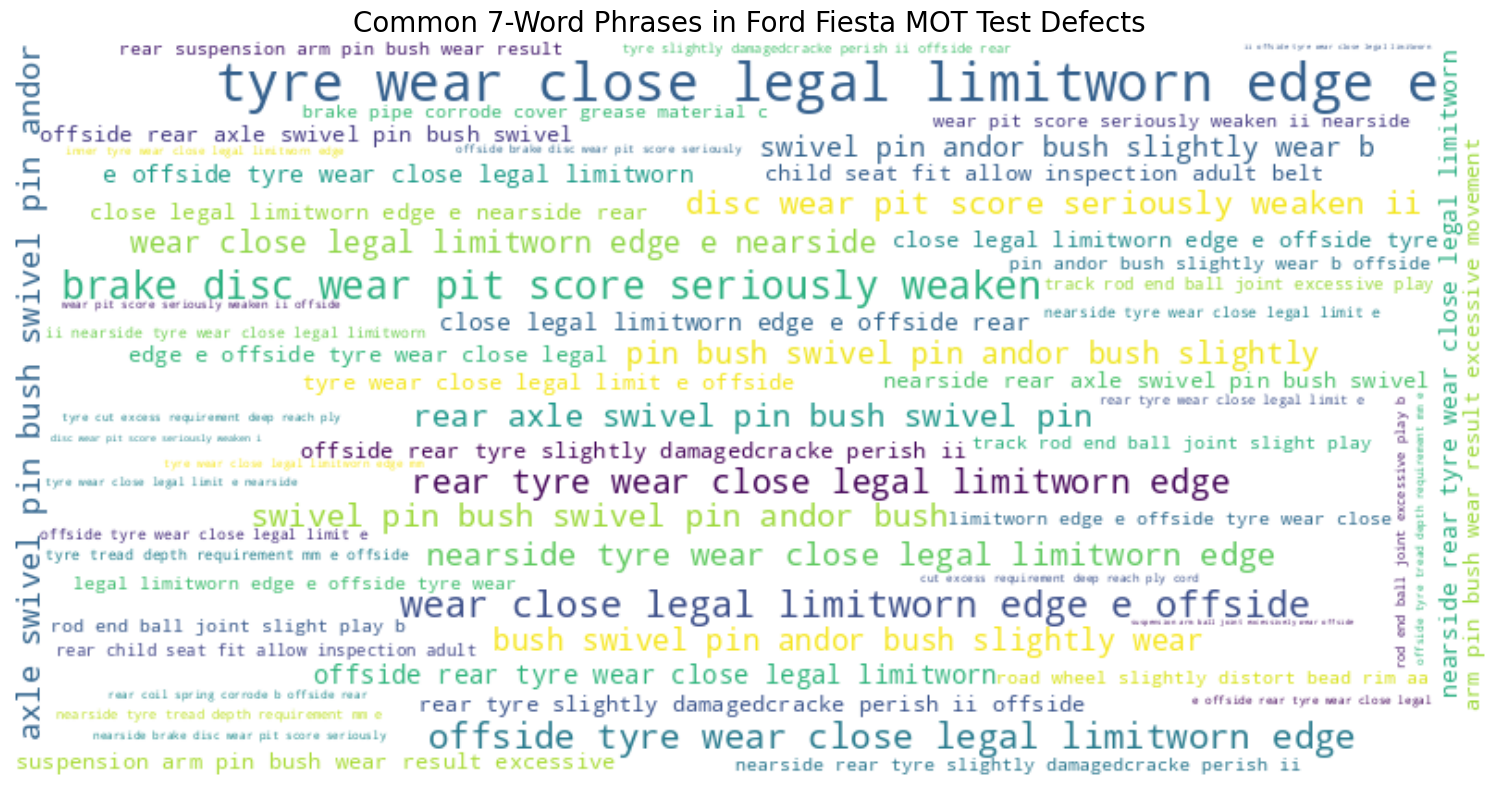

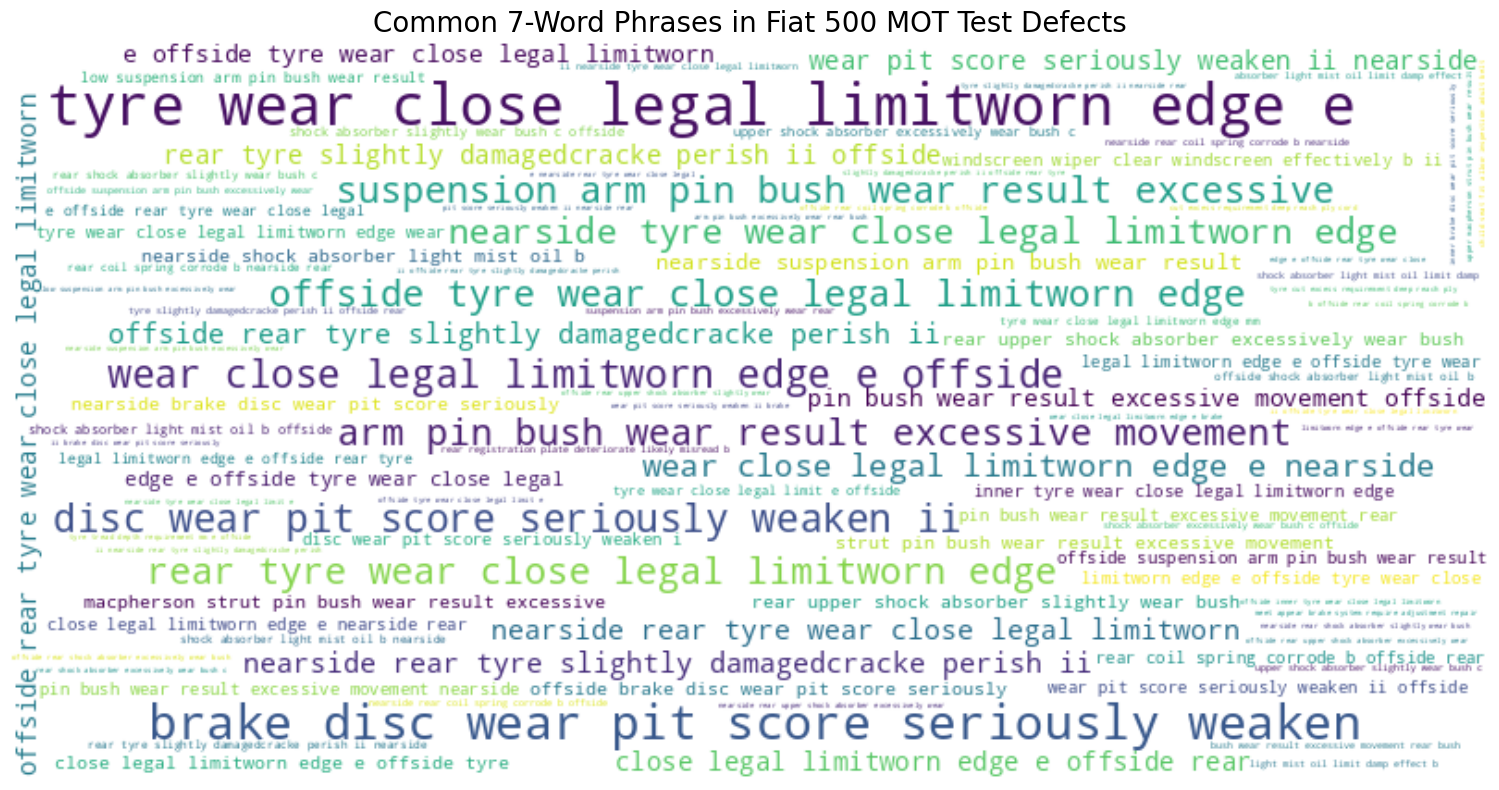

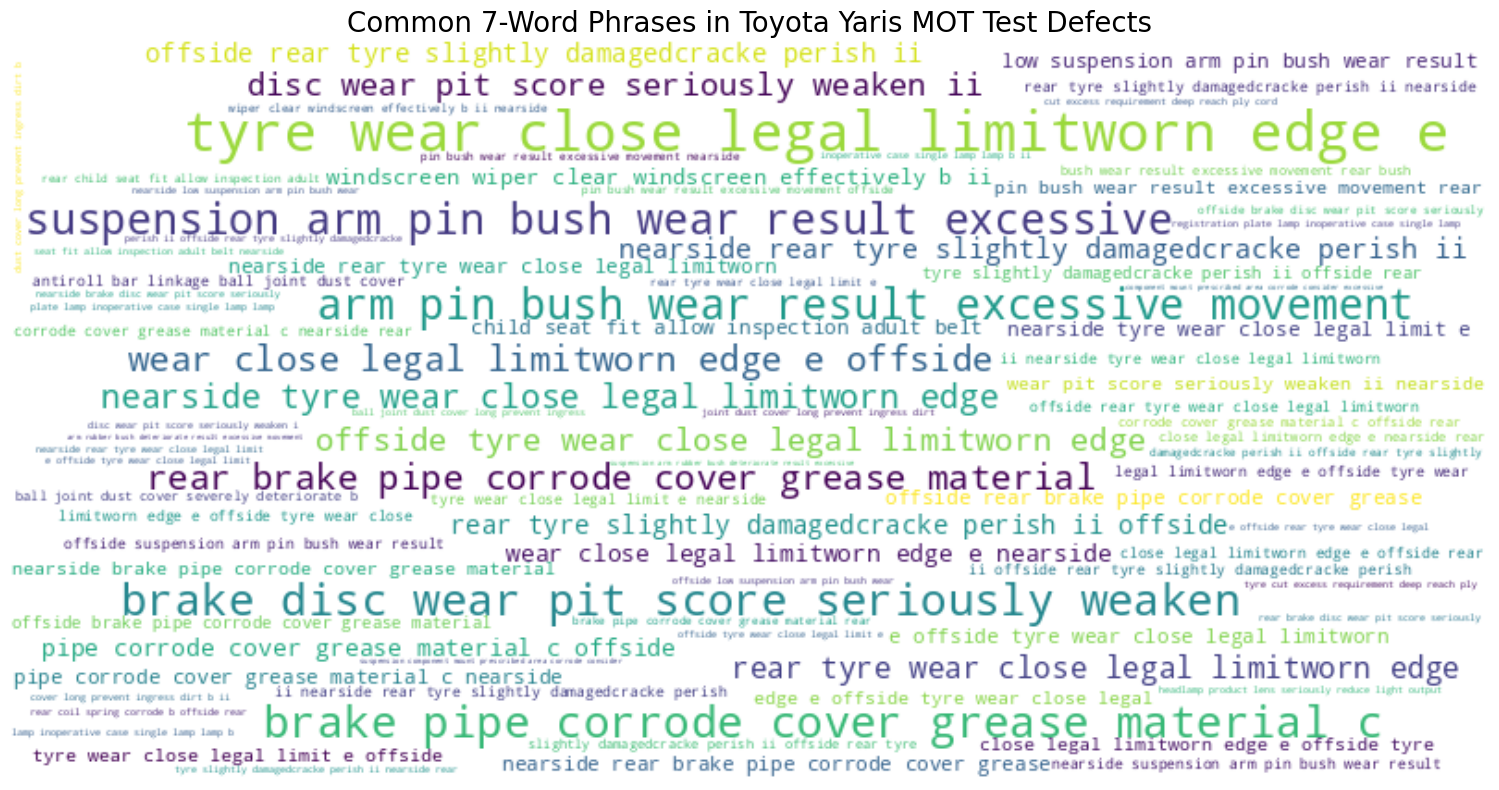

In [122]:
generate_mot_wordcloud(' '.join(mot_ford_fiesta_parsed['defect_text'].fillna(''))[0:1000000], common_stopwords.union({'ford', 'fiesta'}), 'Ford Fiesta')
generate_mot_wordcloud(' '.join(mot_fiat_500_parsed['defect_text'].fillna(''))[0:1000000], common_stopwords.union({'fiat', '500'}), 'Fiat 500')
generate_mot_wordcloud(' '.join(mot_toyota_yaris_parsed['defect_text'].fillna(''))[0:1000000], common_stopwords.union({'toyota', 'yaris'}), 'Toyota Yaris')

# Inital MOT data ming

# Next step topic modelling and sentiment analysis

# LLM summarization 

# Network generation and inferance